[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sachdevkartik/GSoC-2022/blob/main/inference/test1_inference.ipynb)


# __Inferring the trained model of **Task 1** Equivariant Neural Networks__

# __Google colab__
To run in Google colab, please execute the below cell for installing the requisite dependencies.

In [ ]:
# !pip install e2cnn
# !pip install gdown
# %sudo apt install unzip

# __Running Locally__
To run locally, please execute the below cell for installing CUDA, pytorch among other dependencies and set up the conda env. If some of the dependcies are already installed like pytorch or cuda, please cherrypick dependencis from the ```setup.bash``` file

In [ ]:
# %%bash
# bash setup.bash

# __Essential imports__

In [6]:
import sys
import os
import time
import logging
import argparse
import shutil
import torch
import copy
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
from os import listdir
from os.path import join
import torch.optim as optim
from e2cnn import gspaces, nn
import matplotlib.pyplot as plt
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F
from torchvision.transforms import RandomRotation, Pad, Resize, ToTensor, Compose
import torchvision.transforms as transforms
from sklearn.metrics import roc_curve, auc, confusion_matrix
import warnings
from torchsummary import summary
warnings.filterwarnings('ignore')
import gdown
import splitfolders

## __Make required folders for data and models__

In [7]:
# check if the directory for data exists else make it
os.makedirs('data', exist_ok=True)
os.makedirs("model", exist_ok=True)

## __Download data__
The Dataset consists of three classes, strong lensing images with no substructure, subhalo substructure, and vortex substructure. The images have been normalized using min-max normalization.

| S.No | Classes | # Images |
| --- | --- | --- |
| 1. | With subhalo substructure | 12500 |
| 2. | Without substructure | 12500 |
| 3. | Vortex substructure | 12500 |


In [8]:
# check if the compressed data file from gdrive exist 
# else download in the directory
if not os.path.isfile('data/dataset.zip'):
    url = "https://drive.google.com/uc?id=1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A"
    output = "data/dataset.zip"
    gdown.download(url, output, quiet=False)
else:
    print("File exists")

File exists


## __Extract data__
Check if the compressed data file is already extracted else extract data <br>

The data folder looks like: 

```bash
    dataset
    ├── train
    │   ├── no
    │   ├── sphere
    │   └── vort
    └── val
        ├── no
        ├── sphere
        └── vort

```

In [9]:
# initialize the data directory name  
data_dir = 'data/dataset'

if os.path.isdir(data_dir):
    print("Extracted folder exists")
else:
    print("Extracting folder")
    os.system('unzip data/dataset.zip -d data')

Extracted folder exists


In [19]:
# clean up metadata
%%bash
find ./data -type d -name "__MACOSX" -exec rm -rf \;
find ./data -type f -name "*.DS_Store" -exec rm -f {} \;


In [20]:
print(f"Torch: {torch.__version__}")

Torch: 1.6.0


## __Set Config and Hyperparameters__

In [21]:
# Data setting
n_classes = 3               # number of classes to be classified
img_size = 129              # image size (129x129)
sym_group = 'Circular'      # Symmetry group to be used 'Circular'
N = 4                       # Order of the symmetry group


# Training parameters
batch_size = 64             # batch size
epochs = 40                 # number of epochs        
lr = 5e-5                   # learning rate

# optimizer parameters
weight_decay = 1e-7         # L2 penalty
gamma = 0.5                 # factor by which to decrease learning
step_size_opt = 5           # interval to apply optimizer scheduler
use_lr_schedule = False     # To apply LR scheduler or not

seed = 42                   # fixing seed for repeatability
use_cuda = True             # Using CUDA
cuda_idx = 0                # idx of CUDA device to be used


# Path settings
PY_PATH = os.path.abspath('')               # absolute path of jupyter file
data_dir = os.path.join(PY_PATH, data_dir)  # absolute path of dataset


## __Select CUDA device for training__

In [22]:
def get_device(use_cuda=True, cuda_idx=0):
    """Get the CUDA device

    Args:
        use_cuda (Bool): To used CUDA or not
        cuda_idx (int): index of CUDA device 
    
    Returns:
        device: CUDA device(s) being used 
    """
    
    if use_cuda:
        if torch.cuda.is_available():
            assert cuda_idx in range(0, torch.cuda.device_count()),\
                "GPU index out of range. index lies in [{}, {})".format(0, torch.cuda.device_count())
            device = torch.device("cuda:"+str(cuda_idx))
        else:
            print("cuda not found, will switch to cpu")
    else:
        device = torch.device("cpu")
    print(f'Using device = {str(device)}')
    return device

In [23]:
device = get_device(use_cuda, cuda_idx)

Using device = cuda:0


## __Transformations__ 

Following transformations are performed on the dataset:

1. Randomly crop to $128 \times 128$ 
2. Padded to increase to $129 \times 129$
3. Resized to $387 \times 387$
4. Randomly rotate between 0 $^{\circ}$ -180 $^{\circ}$ 
7. Resized to $129 \times 129$.
8. Converting to grayscale
9. Converting PIL image to tensor

Transformation were refered from the existing implementation with equivariant networks mentioned above.

In [24]:
# images are padded to have shape 129x129.
# this allows to use odd-size filters with stride 2 when downsampling a feature map in the model
pad = Pad((0, 0, 1, 1), fill=0)
# to reduce interpolation artifacts (e.g. when testing the model on rotated images),
# we upsample an image by a factor of 3, rotate it and finally downsample it again
resize1 = Resize(387)
resize2 = Resize(129)
totensor = ToTensor()
togray = transforms.Grayscale(num_output_channels=1)

In [25]:
transform_train = transforms.Compose([
    transforms.RandomCrop(128),
    pad,
    resize1,
    RandomRotation(180, resample=Image.BILINEAR, expand=False),
    resize2,
    togray,
    totensor,
])
transform_test = transforms.Compose([
    transforms.RandomCrop(128),
    pad,
    togray,
    totensor,
])

## __Defining custom dataset for given data__

In [26]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, mode, transform=None):
        assert mode in ['train', 'test']

        self.root_dir = root_dir

        if mode == "train":
            self.root_dir = self.root_dir+"/train"
        else:
            self.root_dir = self.root_dir+"/val"

        self.transform = transform
        classes = listdir(self.root_dir) # [join(self.root_dir, x).split('/')[3] for x in listdir(self.root_dir)]
        classes.sort()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        self.imagefilename = []
        self.labels = []
        
        for i in classes:
            for x in listdir(join(self.root_dir, i)):
                self.imagefilename.append(join(self.root_dir, i,x))
                self.labels.append(self.class_to_idx[i])

    
    def __getitem__(self, index):
        image, label = self.imagefilename[index], self.labels[index]
        
        image = np.load(image, allow_pickle=True)[0]
        image = image / image.max() #normalizes data in range 0 - 255
        image = 255 * image
        image  = Image.fromarray(image.astype('uint8')).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def __len__(self):
        return len(self.labels)

In [27]:
trainset = CustomDataset(data_dir,'train',transform_train)
testset = CustomDataset(data_dir, 'test',transform=transform_test)

## __Dataloader__
Loading train and test data with shuffle and given batch size

In [28]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=True)

## __Visualize image samples__

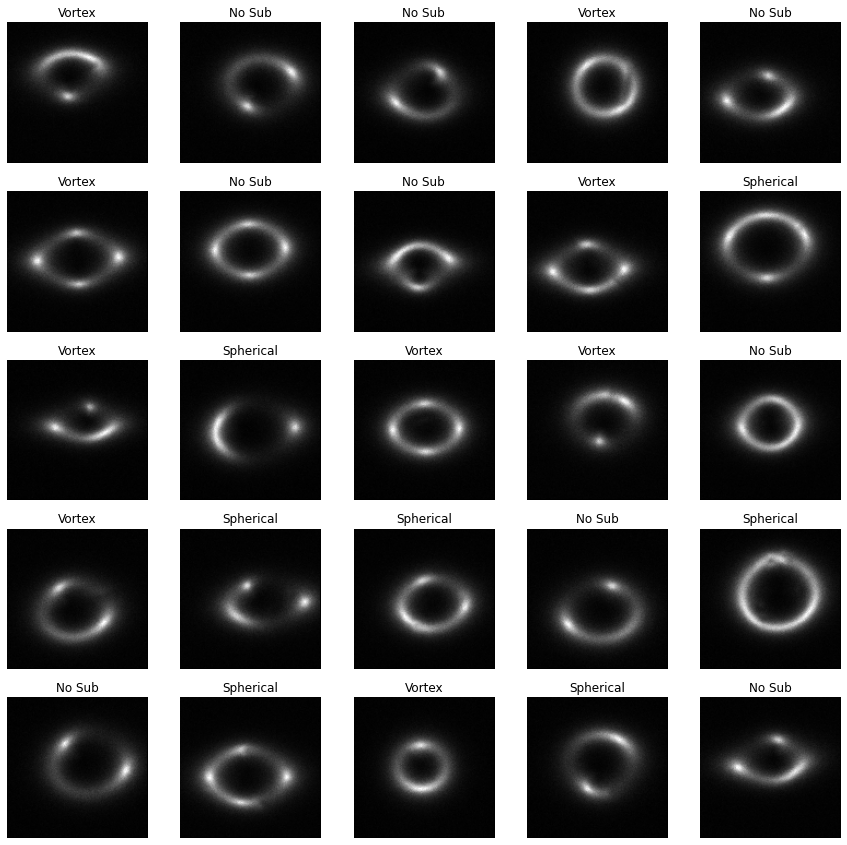

In [29]:
labels_map = {0: 'No Sub',1:'Spherical', 2:'Vortex'}
figure = plt.figure(figsize=(15, 15))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(testset), size=(1,)).item()
    img, label = testset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### **Model Definition**
Since the input images are gray-scale, the input model type will be scalar field. Inside the network, we use regular fields. Finally, group pooling is used to build invariant features. Two fully connected layers perform the final classification.

In [30]:
class Equivariant_Network(torch.nn.Module):
    
    def __init__(self, n_classes=n_classes, sym_group = sym_group, N = N):
        
        super(Equivariant_Network, self).__init__()
        
        # Dihyderal Equivariance
        if sym_group == 'Dihyderal':
            self.r2_act = gspaces.FlipRot2dOnR2(N=N)

        # Circular Equivariance
        elif sym_group == 'Circular':
            self.r2_act = gspaces.Rot2dOnR2(N=N)

        
        # the input image is a scalar field, corresponding to the trivial representation
        in_type = nn.FieldType(self.r2_act, [self.r2_act.trivial_repr])
        
        # we store the input type for wrapping the images into a geometric tensor during the forward pass
        self.input_type = in_type
        print('##### in_type: #####', in_type)
        
        # convolution 1
        # first specify the output type of the convolutional layer
        # we choose 24 feature fields, each transforming under the regular representation of C8
        out_type = nn.FieldType(self.r2_act, 24*[self.r2_act.regular_repr])
        self.block1 = nn.SequentialModule(
            nn.MaskModule(in_type, 129, margin=1),
            nn.R2Conv(in_type, out_type, kernel_size=7, padding=1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        
        # convolution 2
        # the old output type is the input type to the next layer
        in_type = self.block1.out_type
        # the output type of the second convolution layer are 48 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block2 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        self.pool1 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        
        # convolution 3
        # the old output type is the input type to the next layer
        in_type = self.block2.out_type
        # the output type of the third convolution layer are 48 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 48*[self.r2_act.regular_repr])
        self.block3 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        
        # convolution 4
        # the old output type is the input type to the next layer
        in_type = self.block3.out_type
        # the output type of the fourth convolution layer are 96 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block4 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        self.pool2 = nn.SequentialModule(
            nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=2)
        )
        
        # convolution 5
        # the old output type is the input type to the next layer
        in_type = self.block4.out_type
        # the output type of the fifth convolution layer are 96 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 96*[self.r2_act.regular_repr])
        self.block5 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=2, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        
        # convolution 6
        # the old output type is the input type to the next layer
        in_type = self.block5.out_type
        # the output type of the sixth convolution layer are 64 regular feature fields of C8
        out_type = nn.FieldType(self.r2_act, 64*[self.r2_act.regular_repr])
        self.block6 = nn.SequentialModule(
            nn.R2Conv(in_type, out_type, kernel_size=5, padding=1, bias=False),
            nn.InnerBatchNorm(out_type),
            nn.ReLU(out_type, inplace=True)
        )
        self.pool3 = nn.PointwiseAvgPoolAntialiased(out_type, sigma=0.66, stride=1, padding=0)
        
        self.gpool = nn.GroupPooling(out_type)
        
        # number of output channels
        c = self.gpool.out_type.size
        
        # Fully Connected
        self.fully_net = torch.nn.Sequential(
            torch.nn.Linear(43264, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ELU(inplace=True),
            torch.nn.Linear(64, n_classes),
        )
    
    def forward(self, input: torch.Tensor):
        # wrap the input tensor in a GeometricTensor
        # (associate it with the input type)
        # print('input: ', input)
        # print('input: ', self.input_type)
        x = nn.GeometricTensor(input, self.input_type)
        
        # apply each equivariant block
        
        # Each layer has an input and an output type
        # A layer takes a GeometricTensor in input.
        # This tensor needs to be associated with the same representation of the layer's input type
        #
        # The Layer outputs a new GeometricTensor, associated with the layer's output type.
        # As a result, consecutive layers need to have matching input/output types
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool1(x)
        
        x = self.block3(x)
        x = self.block4(x)
        x = self.pool2(x)
        
        x = self.block5(x)
        x = self.block6(x)
        
        # pool over the spatial dimensions
        x = self.pool3(x)
        
        # pool over the group
        x = self.gpool(x)

        # unwrap the output GeometricTensor
        # (take the Pytorch tensor and discard the associated representation)
        x = x.tensor
        
        # classify with the final fully connected layers)
        x = self.fully_net(x.reshape(x.shape[0], -1))
        
        return x
    

## __Loading trained Model__

In [31]:
best_model = Equivariant_Network(
            n_classes=n_classes, 
            sym_group = sym_group, 
            N =N).to(device)

MODEL_PATH = 'model/cnn_state_dict_model.pt'
best_model.load_state_dict(torch.load(MODEL_PATH))


##### in_type: ##### [4-Rotations: {irrep_0}]


<All keys matched successfully>

## __Evaluation__

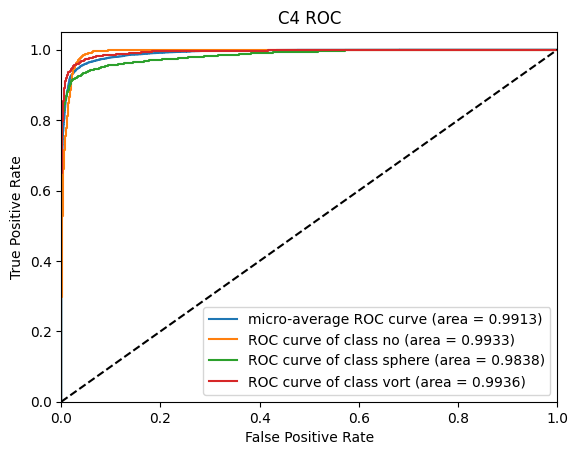

In [32]:
def to_one_hot_vector(num_class, label):
    b = np.zeros((label.shape[0], num_class))
    b[np.arange(label.shape[0]), label] = 1

    return b.astype(int)

plt.rcParams.update(plt.rcParamsDefault)

total = 0
all_test_loss = []
all_test_accuracy = []
label_true_arr = []
label_true_arr_onehot = []
label_pred_arr = []
pred_arr = []

correct = 0
with torch.no_grad():
    best_model.eval()
    for i, (x, t) in enumerate(test_loader):
        x = x.to(device)
        t = t.to(device)
        y = best_model(x)

        pred_arr.append(y.cpu().numpy())


        _, prediction = torch.max(y.data, 1)
        label_pred_arr.append(prediction.cpu().numpy())
        total += t.shape[0]
        correct += (prediction == t).sum().item()
        label_true_arr.append(t.cpu().numpy())

        one_hot_t = to_one_hot_vector(3,t.cpu().numpy())
        label_true_arr_onehot.append(one_hot_t)

y_pred = []
for i in label_pred_arr:
    for j in i:
        y_pred.append(j)
y_pred = np.array(y_pred)        
        
y_true_onehot = []
for i in label_true_arr_onehot:
    for j in i:
        y_true_onehot.append(list(j))
y_true_onehot = np.array(y_true_onehot)

y_score = []
for i in pred_arr:
    for j in i:
        y_score.append(list(j))
y_score = np.array(y_score)

y_true = []
for i in label_true_arr:
    for j in i:
        y_true.append(j)
y_true = np.array(y_true)

fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


inv_map = {v: k for k, v in testset.class_to_idx.items()}



# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_onehot.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class '+ inv_map[i]+ ' (area = {0:0.4f})'
                                   ''.format(roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(sym_group[0]+str(N)+' ROC')
plt.legend(loc="lower right")
plt.show()

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

Confusion matrix, without normalization


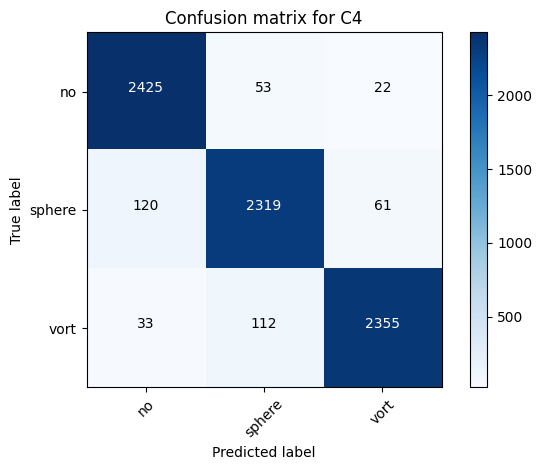

In [36]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[inv_map[0], inv_map[1], inv_map[2]],title='Confusion matrix for '+sym_group[0]+str(N))

## Cite

Inspired from [General E(2)-Equivariant Steerable CNNs](https://arxiv.org/abs/1911.08251).
 
```
@inproceedings{e2cnn,
    title={{General E(2)-Equivariant Steerable CNNs}},
    author={Weiler, Maurice and Cesa, Gabriele},
    booktitle={Conference on Neural Information Processing Systems (NeurIPS)},
    year={2019},
}
```

Apoorva Singh, Yurii Halychanskyi, Marcos Tidball, DeepLense, (2021), GitHub repository, https://github.com/ML4SCI/DeepLense